In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from prophet import Prophet
from sklearn.metrics import mean_absolute_error, mean_squared_error
import os

# --- 1. Load Data ---
RAW_PATH = "../data/raw"
df_train = pd.read_csv(os.path.join(RAW_PATH, "train.csv"))

# Convert date
df_train['date'] = pd.to_datetime(df_train['date'])

In [5]:
# Predicting for 54 stores x 3000 items takes hours. 
# For the baseline, we pick Store 44 (one of the busiest) and aggregate total sales.
store_id = 44
print(f"📉 Modeling for Store ID: {store_id}")

df_store = df_train[df_train['store_nbr'] == store_id].copy()

# Aggregating to Daily Total Sales (ignoring product categories for now)
df_daily = df_store.groupby('date')['sales'].sum().reset_index()

# --- 3. Prophet Formatting (Crucial Step) ---
# Prophet requires columns named 'ds' (Date) and 'y' (Target)
df_prophet = df_daily.rename(columns={'date': 'ds', 'sales': 'y'})

# --- 4. Train/Test Split ---
# In Time Series, we CANNOT use random split. We must cut by date.
# Test set = Last 28 days
test_days = 28
train_df = df_prophet.iloc[:-test_days]
test_df = df_prophet.iloc[-test_days:]

print(f"Train samples: {len(train_df)}")
print(f"Test samples: {len(test_df)}")

📉 Modeling for Store ID: 44
Train samples: 1656
Test samples: 28


🧠 Training Prophet Model...


13:36:38 - cmdstanpy - INFO - Chain [1] start processing
13:36:39 - cmdstanpy - INFO - Chain [1] done processing



📊 --- Baseline Results (Store 44) ---
MAE: 4173.34
RMSE: 5140.87


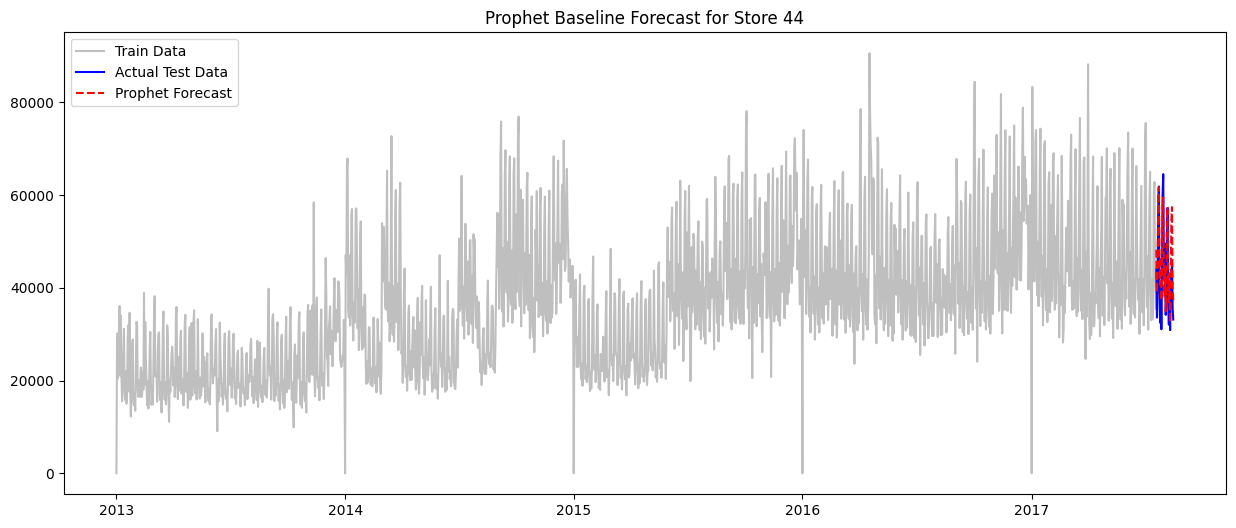

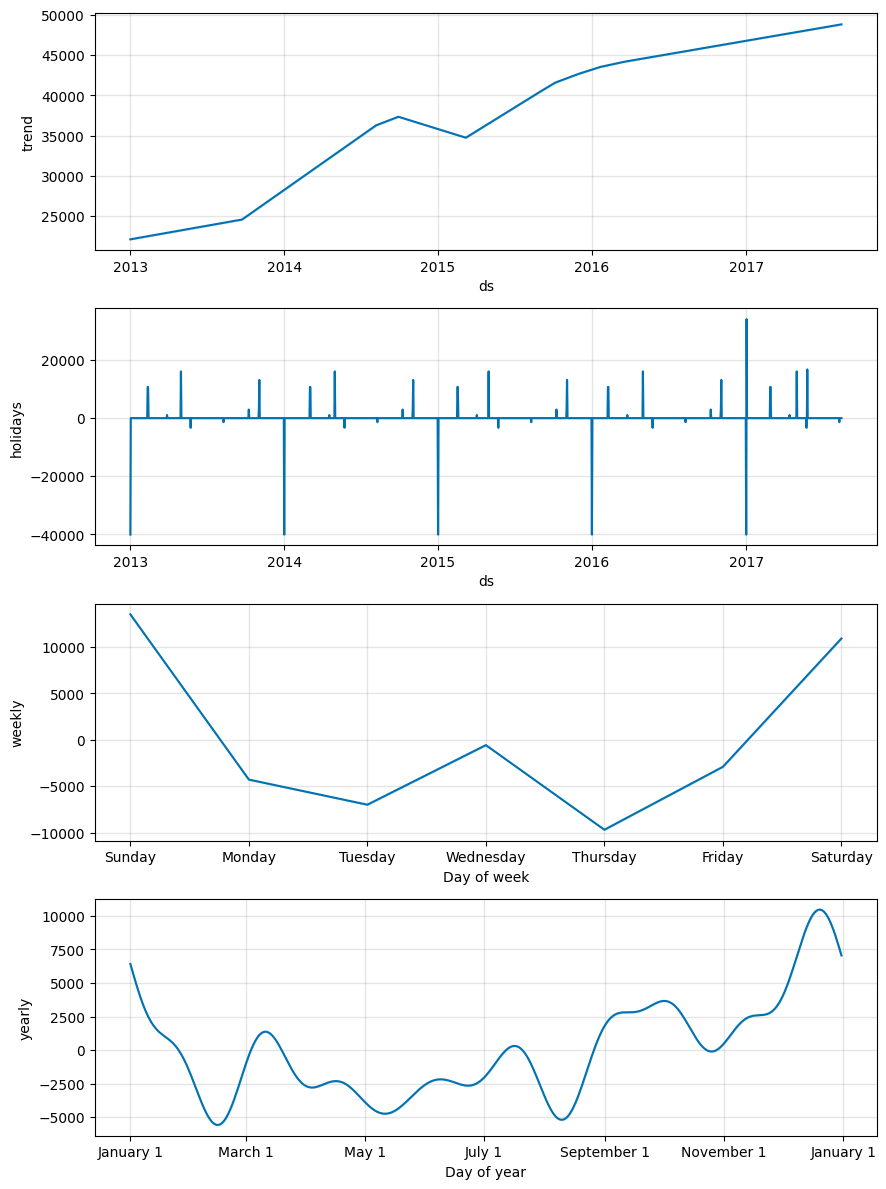

In [6]:
# --- 5. Training Prophet ---
# We add country holidays to handle New Year's automatically
model = Prophet(yearly_seasonality=True, weekly_seasonality=True)
model.add_country_holidays(country_name='EC') # Ecuador holidays

print("🧠 Training Prophet Model...")
model.fit(train_df)

# --- 6. Prediction ---
# Create future dataframe (28 days)
future = model.make_future_dataframe(periods=test_days)
forecast = model.predict(future)

# --- 7. Evaluation ---
# Extract predictions for the test period
y_true = test_df['y'].values
y_pred = forecast['yhat'].iloc[-test_days:].values

# Metrics
mae = mean_absolute_error(y_true, y_pred)
rmse = np.sqrt(mean_squared_error(y_true, y_pred))

print(f"\n📊 --- Baseline Results (Store {store_id}) ---")
print(f"MAE: {mae:.2f}")
print(f"RMSE: {rmse:.2f}")

# Visualizing the forecast vs actual
plt.figure(figsize=(15, 6))
plt.plot(train_df['ds'], train_df['y'], label='Train Data', color='gray', alpha=0.5)
plt.plot(test_df['ds'], test_df['y'], label='Actual Test Data', color='blue')
plt.plot(test_df['ds'], y_pred, label='Prophet Forecast', color='red', linestyle='--')
plt.title(f"Prophet Baseline Forecast for Store {store_id}")
plt.legend()
plt.show()

# Visualize Components (Trend, Weekly, Yearly)
fig2 = model.plot_components(forecast)